    year    population           gdp  householdMinIncome          death  \
0   2025  3.494477e+07  1.673647e+06         8833.980000  219012.135654   
1   2026  3.538372e+07  1.729595e+06         8989.796923  226550.908497   
2   2027  3.582266e+07  1.786386e+06         9145.613846  234313.947932   
3   2028  3.626160e+07  1.844020e+06         9301.430769  242301.253959   
4   2029  3.670054e+07  1.902496e+06         9457.247692  250512.826579   
5   2030  3.713948e+07  1.961816e+06         9613.064615  258948.665791   
6   2031  3.757843e+07  2.021979e+06         9768.881538  267608.771596   
7   2032  3.801737e+07  2.082985e+06         9924.698462  276493.143992   
8   2033  3.845631e+07  2.144834e+06        10080.515385  285601.782982   
9   2034  3.889525e+07  2.207525e+06        10236.332308  294934.688563   
10  2035  3.933420e+07  2.271060e+06        10392.149231  304491.860737   
11  2036  3.977314e+07  2.335437e+06        10547.966154  314273.299503   
12  2037  4.021208e+07  2

c:\Users\Sukonbu\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\Sukonbu\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


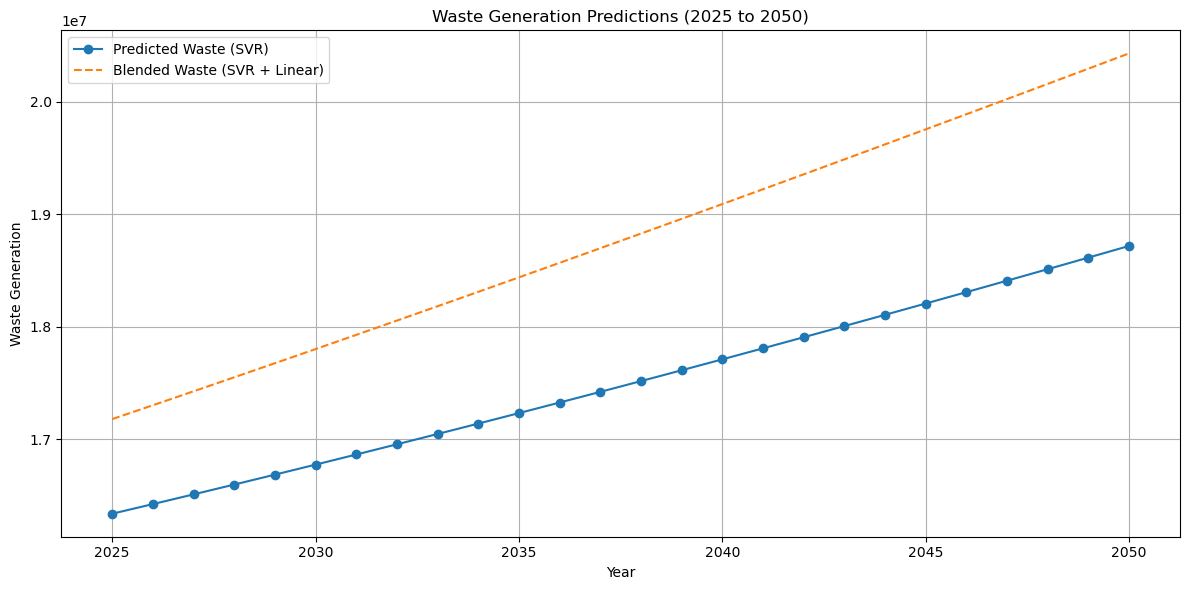

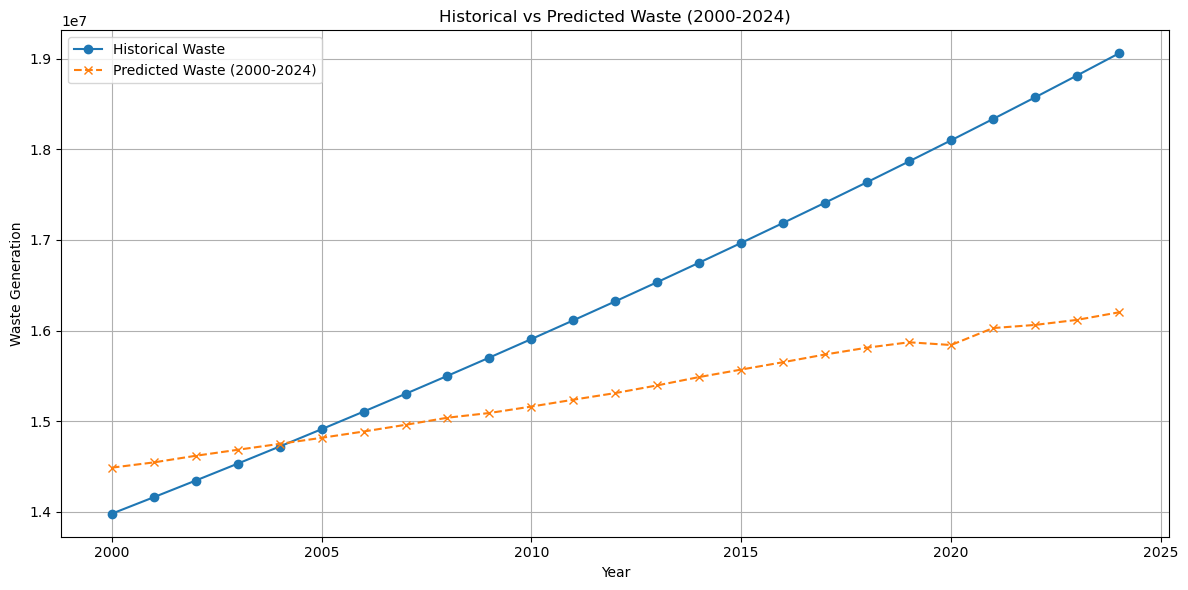

    year     waste  predicted_waste
0   2000  13979399     1.448742e+07
1   2001  14161131     1.454548e+07
2   2002  14345225     1.461870e+07
3   2003  14531713     1.468468e+07
4   2004  14720625     1.474997e+07
5   2005  14911992     1.481685e+07
6   2006  15105848     1.488624e+07
7   2007  15302224     1.496035e+07
8   2008  15501153     1.503884e+07
9   2009  15702667     1.509084e+07
10  2010  15906802     1.516182e+07
11  2011  16113590     1.523763e+07
12  2012  16323066     1.531084e+07
13  2013  16535266     1.539563e+07
14  2014  16750224     1.548775e+07
15  2015  16967977     1.557013e+07
16  2016  17188560     1.565149e+07
17  2017  17412011     1.573655e+07
18  2018  17638367     1.581183e+07
19  2019  17867665     1.587112e+07
20  2020  18099945     1.584102e+07
21  2021  18335244     1.602798e+07
22  2022  18573601     1.606267e+07
23  2023  18815058     1.611829e+07
24  2024  19059654     1.620177e+07


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
data = pd.read_csv('Data/cloneData.csv')

# Initialize scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale input and target variables
X = data[['population', 'gdp', 'householdMinIncome', 'death']]  # Exclude 'year'
y = data['waste'].values.reshape(-1, 1)
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Train the SVR model with hyperparameter tuning
param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 1],
    'epsilon': [0.1, 0.5]
}
svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y_scaled.ravel())
best_svr = grid_search.best_estimator_

# Get user input for the prediction year
end_year = int(input("Enter the year you want to predict up to (e.g., 2100): "))

# Predict missing features using trends
predicted_features = ['population', 'gdp', 'householdMinIncome', 'death']
feature_predictions = {}

# Add polynomial or exponential trend prediction for each feature
def exponential_growth(x, a, b, c):
    return a * np.exp(b * x) + c

for feature in predicted_features:
    if feature in data.columns:
        trend_data = data[['year', feature]].dropna()

        if feature == 'gdp':
            # Use polynomial regression for GDP
            poly = PolynomialFeatures(degree=2)
            X_poly = poly.fit_transform(trend_data[['year']])
            poly_model = LinearRegression()
            poly_model.fit(X_poly, trend_data[feature])
            prediction_years = pd.DataFrame({'year': list(range(2025, end_year + 1))})
            X_future_poly = poly.transform(prediction_years[['year']])
            feature_predictions[feature] = poly_model.predict(X_future_poly)
        elif feature == 'death':
            # Use polynomial regression for death
            poly = PolynomialFeatures(degree=2)
            X_poly = poly.fit_transform(trend_data[['year']])
            poly_model = LinearRegression()
            poly_model.fit(X_poly, trend_data[feature])
            prediction_years = pd.DataFrame({'year': list(range(2025, end_year + 1))})
            X_future_poly = poly.transform(prediction_years[['year']])
            feature_predictions[feature] = poly_model.predict(X_future_poly)
        else:
            # Use linear regression for householdMinIncome
            linear_model = LinearRegression()
            linear_model.fit(trend_data[['year']], trend_data[feature])
            prediction_years = pd.DataFrame({'year': list(range(2025, end_year + 1))})
            feature_predictions[feature] = linear_model.predict(prediction_years[['year']])

# Combine predictions into a DataFrame
prediction_data = pd.DataFrame({
    'year': list(range(2025, end_year + 1))
})
for feature in predicted_features:
    prediction_data[feature] = feature_predictions.get(feature, [0] * len(prediction_data))

# Dynamic capping based on extended growth rates
for feature in predicted_features:
    if feature in data.columns:
        # Calculate historical growth rate
        growth_rate = (data[feature].iloc[-1] - data[feature].iloc[0]) / data[feature].iloc[0]
        extended_growth_rate = growth_rate * 1.5  # Increase growth rate by 50%
        prediction_years = prediction_data['year'] - data['year'].iloc[-1]
        max_value = data[feature].iloc[-1] * (1 + extended_growth_rate) ** prediction_years
        min_value = data[feature].min() * 0.8  # Allow 20% decrease from historical min
        prediction_data[feature] = prediction_data[feature].clip(lower=min_value, upper=max_value)

# Scale adjusted prediction data
scaler_X.fit(np.vstack([X[['population', 'gdp', 'householdMinIncome', 'death']], prediction_data[['population', 'gdp', 'householdMinIncome', 'death']].values]))
X_prediction_scaled = scaler_X.transform(prediction_data[['population', 'gdp', 'householdMinIncome', 'death']])

# Predict waste generation using the SVR model
y_prediction_scaled = best_svr.predict(X_prediction_scaled)
y_prediction = scaler_y.inverse_transform(y_prediction_scaled.reshape(-1, 1)).ravel()

# Add waste predictions to the DataFrame
prediction_data['predicted_waste'] = y_prediction

# Add linear regression trend for comparison
trend_model = LinearRegression()
trend_model.fit(data[['year']], data['waste'])
trend_predictions = trend_model.predict(prediction_data[['year']].values.reshape(-1, 1))

# Blend SVR and linear regression predictions
alpha = 0.7  # Weight for SVR
prediction_data['blended_waste'] = alpha * prediction_data['predicted_waste'] + (1 - alpha) * trend_predictions

# Save predictions to CSV
prediction_data.to_csv(f'Waste_Predictions_2025_to_{end_year}.csv', index=False)

# Display results
print(prediction_data)

# Prepare test data with correct features
X_test = data[['population', 'gdp', 'householdMinIncome', 'death']]
X_test_scaled = scaler_X.transform(X_test.to_numpy())

# Calculate evaluation metrics on test data
y_test_pred_scaled = best_svr.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_test_actual = scaler_y.inverse_transform(y.reshape(-1, 1))

mae = mean_absolute_error(y_test_actual, y_test_pred)
mse = mean_squared_error(y_test_actual, y_test_pred)
r2 = r2_score(y_test_actual, y_test_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(prediction_data['year'], prediction_data['predicted_waste'], label='Predicted Waste (SVR)', marker='o')
plt.plot(prediction_data['year'], prediction_data['blended_waste'], label='Blended Waste (SVR + Linear)', linestyle='--')
plt.title(f'Waste Generation Predictions (2025 to {end_year})')
plt.xlabel('Year')
plt.ylabel('Waste Generation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Predict waste for 2000 to 2024
comparison_years = data[data['year'].between(2000, 2024)]
X_comparison = comparison_years[['population', 'gdp', 'householdMinIncome', 'death']]
y_comparison_actual = comparison_years['waste'].values

# Scale comparison data for 2000-2024
X_comparison_scaled = scaler_X.transform(X_comparison.to_numpy())

# Predict waste using the SVR model
y_comparison_scaled = best_svr.predict(X_comparison_scaled)
y_comparison_predicted = scaler_y.inverse_transform(y_comparison_scaled.reshape(-1, 1)).ravel()

# Add predicted waste to the comparison DataFrame
comparison_years['predicted_waste'] = y_comparison_predicted

# Plot historical vs predicted waste
plt.figure(figsize=(12, 6))
plt.plot(comparison_years['year'], comparison_years['waste'], label='Historical Waste', marker='o')
plt.plot(comparison_years['year'], comparison_years['predicted_waste'], label='Predicted Waste (2000-2024)', linestyle='--', marker='x')
plt.title('Historical vs Predicted Waste (2000-2024)')
plt.xlabel('Year')
plt.ylabel('Waste Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display comparison DataFrame
print(comparison_years[['year', 'waste', 'predicted_waste']])
